## Example 2: Challenges in Identifiability

Here we will explore inference when there is not a single unique set of parameters.

In [1]:
import sys
import os

# Add repo root to Python path (one level up from examples/)
sys.path.append(os.path.abspath(".."))  

from src.parsing import *
from CRN_Simulation.CRN import CRN

import numpy as np
import random

In [2]:
# Determine Stochiometric, Reactant and names of reactions
species_names = ["X1", "X2"]

# Define complexes (example: bi-molecular)
complexes = np.array([[0, 0, 0, 1, 1, 2],
                      [0, 1, 2, 0, 1, 0]])

# Create Reactant, Product, Stochiometric Matrix, Define Compatible Reactions and Everything Needed for CRN
reactant_matrix, product_matrix, stoichiometric_matrix, reaction_names, parameter_names, compatible_reactions = generate_reactions(complexes, species_names)

# Plot some output to the screen
print(f"Total reactions generated: {len(reaction_names)}")
max_show = 3
print("Some Reaction Names:", reaction_names[:max_show])

print("Some Non-Unique Stoichiometric Changes")
count_shown = 0
for deltaX, rxn_indices in compatible_reactions.items():
    if len(rxn_indices) > 1:
        deltaX_clean = tuple(int(x) for x in deltaX)
        # Grab all reaction names
        rxn_names = [reaction_names[i] for i in rxn_indices]
        print(f"ΔX = {deltaX_clean} → indices: {rxn_indices}, reactions: {rxn_names}")
        count_shown += 1
        if count_shown >= max_show:
            break

Total reactions generated: 30
Some Reaction Names: ['Empty_to_X2:', 'Empty_to_2X2:', 'Empty_to_X1:']
Some Non-Unique Stoichiometric Changes
ΔX = (0, 1) → indices: [0, 6, 18], reactions: ['Empty_to_X2:', 'X2_to_2X2:', 'X1_to_X1+X2:']
ΔX = (1, 0) → indices: [2, 8, 19], reactions: ['Empty_to_X1:', 'X2_to_X1+X2:', 'X1_to_2X1:']
ΔX = (0, -1) → indices: [5, 11, 23], reactions: ['X2_to_Empty:', '2X2_to_X2:', 'X1+X2_to_X1:']


In [3]:
##########################
# Set up Reaction System #
##########################

selected_rxns  = ["Empty_to_X1", "X1_to_2X1","X1+X2_to_X2"]
selected_rates = [1.0, 1.0,0.1]  # "Empty_to_X1", "X1_to_2X1","X2+X1_to_X2"


(CRN_stoichiometric_matrix,
CRN_reaction_names,
 CRN_parameter_names,
 CRN_propensities,
 CRN_parameter_values,
 CRN_indices) = build_subCRN_from_names(
    reactant_matrix,
    product_matrix,
    stoichiometric_matrix,
    reaction_names,
    parameter_names,
    species_names,
    selected_names=selected_rxns,
    rates=selected_rates
)

rn = CRN(
    species_names=species_names,
    stoichiometric_matrix=CRN_stoichiometric_matrix,
    parameters_names=CRN_parameter_names,
    reaction_names=CRN_reaction_names,
    propensities=CRN_propensities
)

print("CRN created.")
print("Reaction indices:", CRN_indices)
print("Parameter values:", CRN_parameter_values)

CRN created.
Reaction indices: [2, 19, 21]
Parameter values: {'k2': 1.0, 'k19': 1.0, 'k21': 0.1}


Initial state: {'X1': np.int64(0), 'X2': np.int64(5)}
Trajectory saved to ../data/example2_trajectory.json
CRN trajectory saved to ../data/example2_trajectory.json


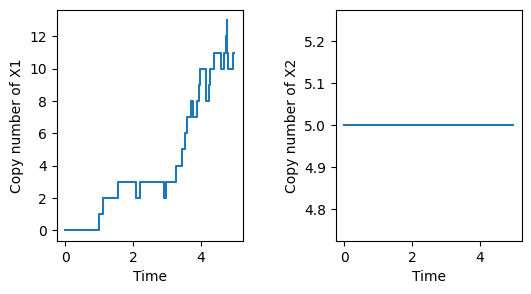

In [4]:
data_dir = "../data"  # relative to examples/ folder
os.makedirs(data_dir, exist_ok=True)

###############################
# Generate trajectory for CRN #
###############################
# Example: 2D species, X1 starts at 0, X2 starts at 10
species_min = [0, 5]
species_max = [0, 5]

time_list, state_list = generate_single_trajectory(
    rn,
    CRN_parameter_values,
    species_names,
    finalTime=5,   # adjust as needed
    minVal=species_min,
    maxVal=species_max,
    seed=42          # for reproducibility
)

trajectory_file = os.path.join(data_dir, "example2_trajectory.json")
save_trajectory(time_list, state_list, filename=trajectory_file)
print(f"CRN trajectory saved to {trajectory_file}")

In [5]:
# Parse trajectories for CRN1
print("Parsing trajectory for CRN1")
unique_changes, unique_states, jump_counts, waiting_times, propensities = parse_trajectory(
    state_list, time_list, reactant_matrix, compatible_reactions,verbose=True)
print("---------")
# Print basic summary
print("Finished parsing trajectories. Summary:")
print(f"CRN1: {len(unique_states)} unique states observed")

Parsing trajectory for CRN1
Tracking 18 unique stoichiometric changes (single trajectory).
Trajectory length: 31 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 14 unique states.
---------
Finished parsing trajectories. Summary:
CRN1: 14 unique states observed


In [6]:
unique_states

[(0, 5),
 (1, 5),
 (2, 5),
 (3, 5),
 (4, 5),
 (5, 5),
 (6, 5),
 (7, 5),
 (8, 5),
 (9, 5),
 (10, 5),
 (11, 5),
 (12, 5),
 (13, 5)]